<a href="https://colab.research.google.com/github/dipakbhandare09/DLproject-Image-generation/blob/main/Anime_Faces_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anime-Faces-Generation Using Generative Adversarial Networks.**

In [90]:
import os
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

To generate the anime face we use the **anime faces dataset** from kaggle.

# Downloading Dataset.

In [91]:
#!pip install opendatasets

Defaulting to user installation because normal site-packages is not writeable


In [92]:
import os

In [93]:
import opendatasets as od

In [94]:
#od.download("https://www.kaggle.com/datasets/splcher/animefacedataset/code")


In [95]:
os.listdir("Downloads/animefacedataset")

['.DS_Store', 'images']

There is only one folder 'images' where all difrenet images of anime faces are present.

In [96]:
image_size= 64 
batch_size = 128
stats = (0.5,0.5,0.5) , (0.5,0.5,0.5)
data_path = "Downloads/animefacedataset"

***Let's load this dataset using the ImageFolder class from torchvision.***

In [97]:
train_ds =ImageFolder(data_path , transform= T.Compose([
            T.Resize(image_size), # Resizing the images 
            T.CenterCrop(image_size), #croping the images of size 64 from center of images
            T.ToTensor(),  # transforming images into the tensors
            T.Normalize(*stats) # Normalizine the images tensors in range between (-1,1)
            ]))

***Traning dataloaders***

In [98]:
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle = True,
                      num_workers=3,
                      pin_memory=True)

In [99]:
x_image= os.listdir("Downloads/animefacedataset/images")[1]
len(os.listdir("Downloads/animefacedataset/images"))

63565

***Total Images = 63565***

# Display Images in Batches 

In [100]:
def denorm_images(image_tensors):
    return image_tensors*stats[1][0] + stats[0][0]

In [101]:
def show_images(image , nmax=64):
    fig,ax = plt.subplots(figsize= (8,8))
    ax.imshow(make_grid(denorm_images(image.detach()[ : nmax]),nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
    for images , _ in dl:
        show_images(images, nmax)
        break

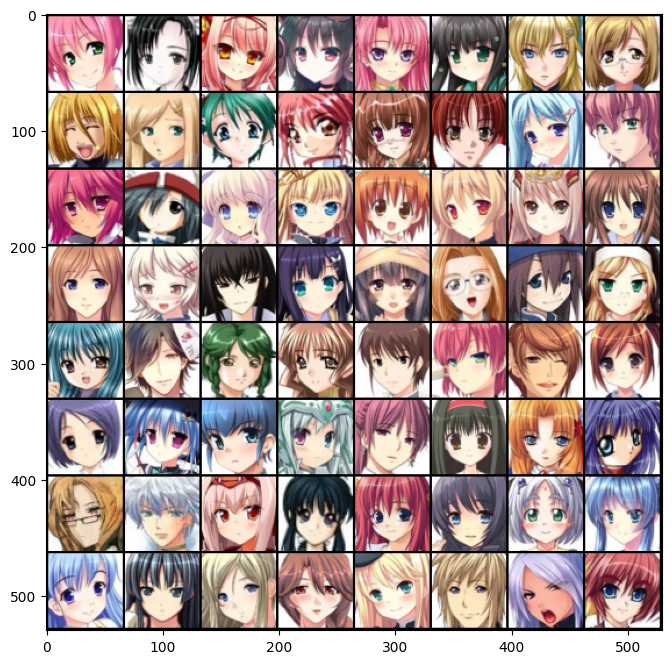

In [102]:
show_batch(train_dl)

#GPU
Graphics processing unit, a specialized processor originally designed to accelerate graphics rendering.

**CUDA is language to communicate with GPU.**

In [103]:
import torch
torch.cuda.is_available()

False

In [104]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [105]:
device = get_default_device()
device

device(type='cpu')

**Loading Traing dataloader on device GPU.**

In [106]:
train_dl = DeviceDataLoader(train_dl, device)

# **Discriminator**

The discriminator takes an image as input, and tries to classify it as "real" or "generated".
we use the convulution neural network which return a single output for every image.

so based on the discriminator output we predict that the image is from actual dataset.

if Discriminator value 0 then its probability that the image generated from generator.

and if discriminator value closed to 1  then its probabilty that the image taken from actual dataset.

In [107]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

***Loading discriminator on device***

In [108]:
discriminator = to_device(discriminator, device)

# **Generator**
generator used to generate the random images from the tesors.

The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28.

**ConvTranspose2d -->  transposed convolution (also referred to as a deconvolution).**



In [109]:
latent_size = 128

In [110]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

***genarating batch of random images using the tensors***

torch.Size([128, 3, 64, 64])


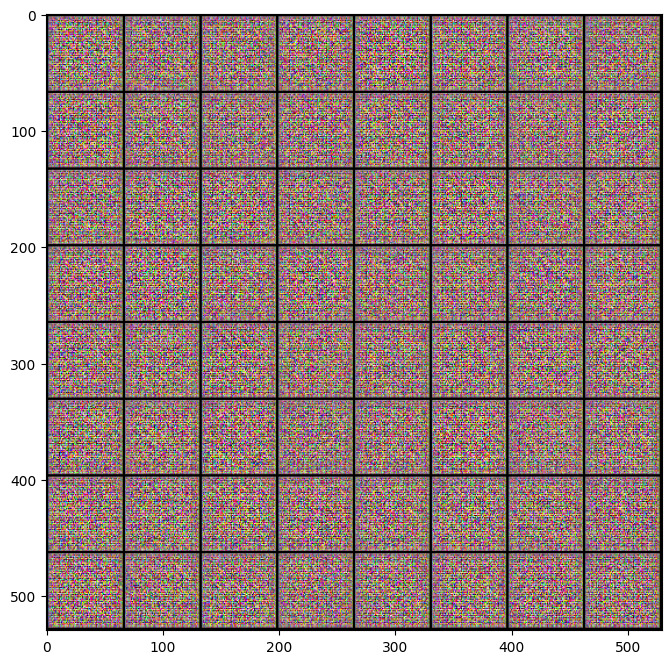

In [111]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

***Loading generator on device***

In [112]:
generator = to_device(generator, device)

# Discriminator Training
**Our assumption here is that The Discriminator always predict 1 for real images and 0 for fake images generated by generator .**
 
So to train the Discriminator We use the **Binary Cross Entropy** As Loss function.

In [113]:
def train_discriminator(real_images, opt_d):
    # setting all gradients to 0
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)

    loss = real_loss + fake_loss
    loss.backward() # calculating the gradients of loss
    opt_d.step() # Modify the weights of Discriminator .
    # make slightly better so that the discrminator get slightly better.
    return loss.item()

# Training Generator.
We generate a batch of images using the generator, pass the into the discriminator.

We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [114]:
def train_generator(opt_g):
    # setting all gradients to 0
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [115]:
from torchvision.utils import save_image

In [116]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm_images(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


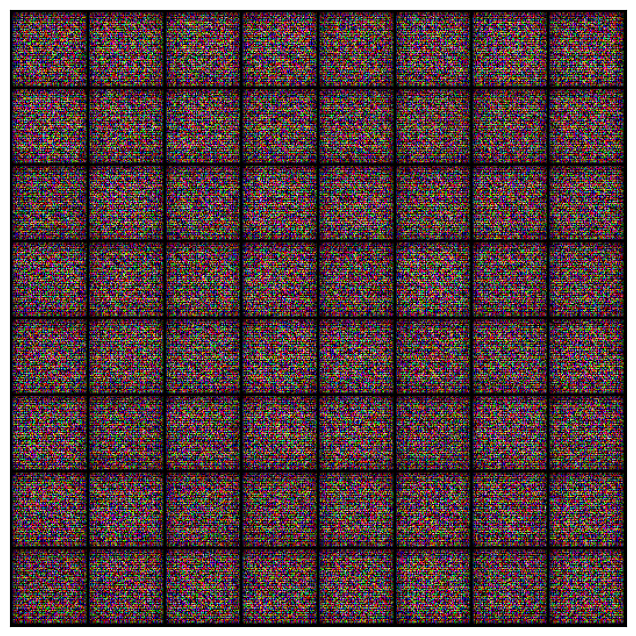

In [117]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

# Final Model

In [118]:
from tqdm.notebook import tqdm

In [119]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    # Losses & scores
    losses_g = []
    losses_d = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # discriminator on each batch of data 
            loss_d= train_discriminator(real_images, opt_d)
            #generstor  on each batch of data 
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d

In [120]:
lr = 0.0002
epochs = 10

In [121]:
history = fit(epochs, lr)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

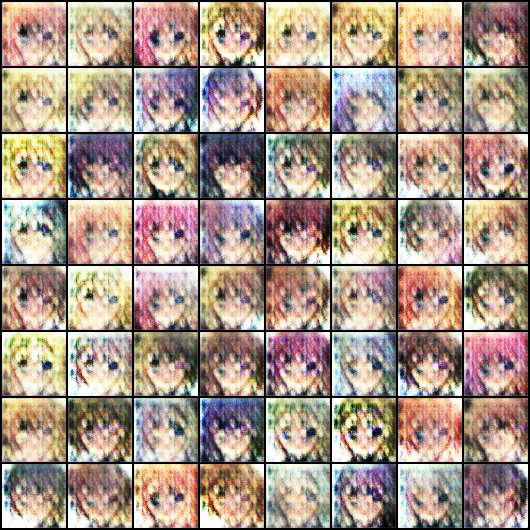

In [ ]:
Image('./generated/generated-images-0001.png')

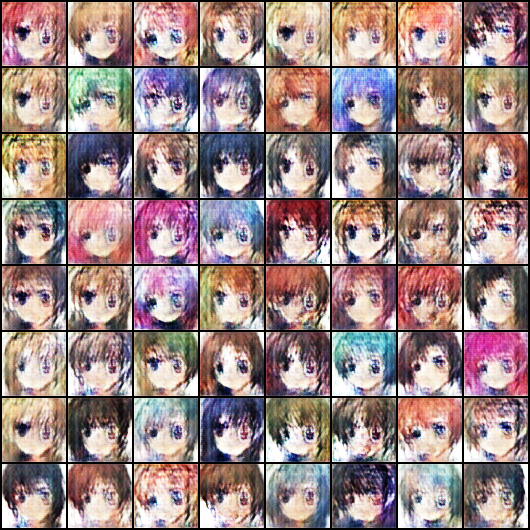

In [ ]:
Image('./generated/generated-images-0003.png')

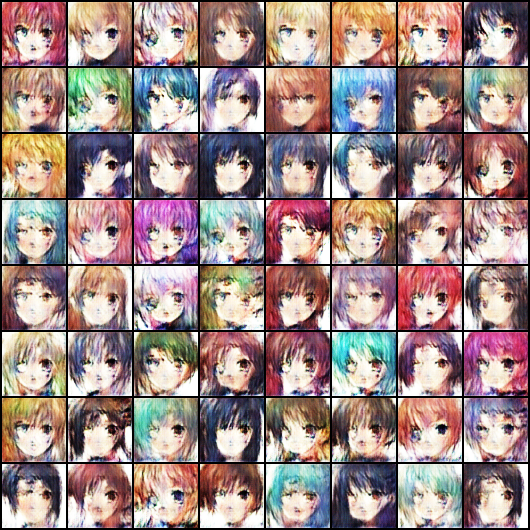

In [ ]:
Image('./generated/generated-images-0006.png')

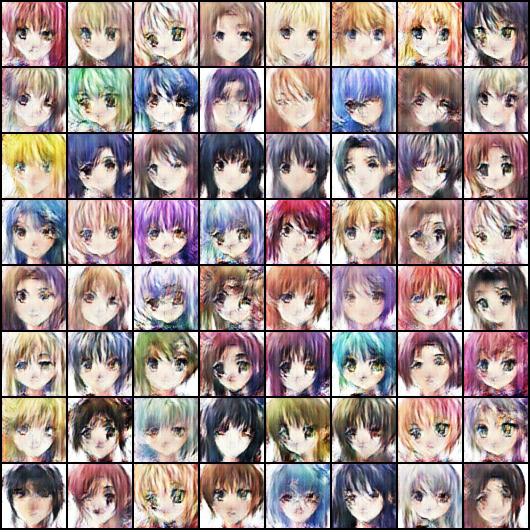

In [ ]:
Image('./generated/generated-images-0008.png')

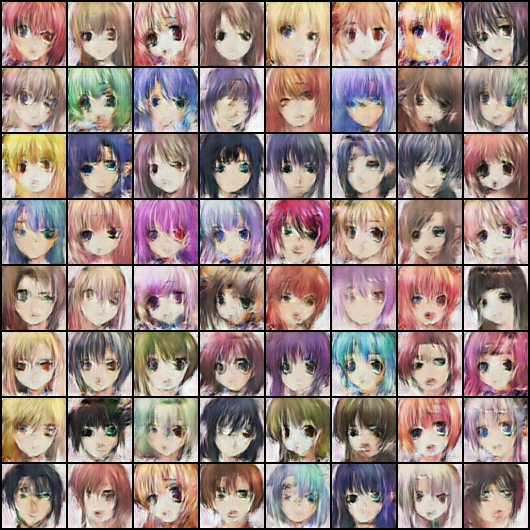

In [ ]:
Image('./generated/generated-images-0010.png')

We See that the anime faces are generated succefuly which look very similar to the actual one similar.